# Exploratory analysis on volume correlations

In [137]:
from itertools import combinations_with_replacement

import graspologic as gp
import hyppo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

from pkg.data import (
    GENOTYPES,
    HEMISPHERE_STRUCTURES,
    HEMISPHERES,
    SUPER_STRUCTURES,
    load_vertex_metadata,
    load_volume_corr,
)

## Plot the data

In [2]:
def set_theme(
    theme=None,
    spine_right=False,
    spine_top=False,
    spine_left=True,
    spine_bottom=True,
    axes_edgecolor="black",
    tick_color="black",
    axes_labelcolor="black",
    text_color="black",
    context="talk",
    tick_size=0,
    font_scale=1,
):
    if theme is None:
        rc_dict = {
            "axes.spines.right": spine_right,
            "axes.spines.top": spine_top,
            "axes.spines.left": spine_left,
            "axes.spines.bottom": spine_bottom,
            "axes.edgecolor": axes_edgecolor,
            "ytick.color": tick_color,
            "xtick.color": tick_color,
            "axes.labelcolor": axes_labelcolor,
            "text.color": text_color,
            "pdf.fonttype": 42,
            "ps.fonttype": 42,
            "font.family": "sans-serif",
            "font.sans-serif": ["Arial"],
            "xtick.major.size": tick_size,
            "ytick.major.size": tick_size,
        }

In [5]:
# Load the data

correlations, labels = load_volume_corr()

(
    vertex_name,
    vertex_hemispheres,
    vertex_structures,
    vertex_hemisphere_structures,
) = load_vertex_metadata()

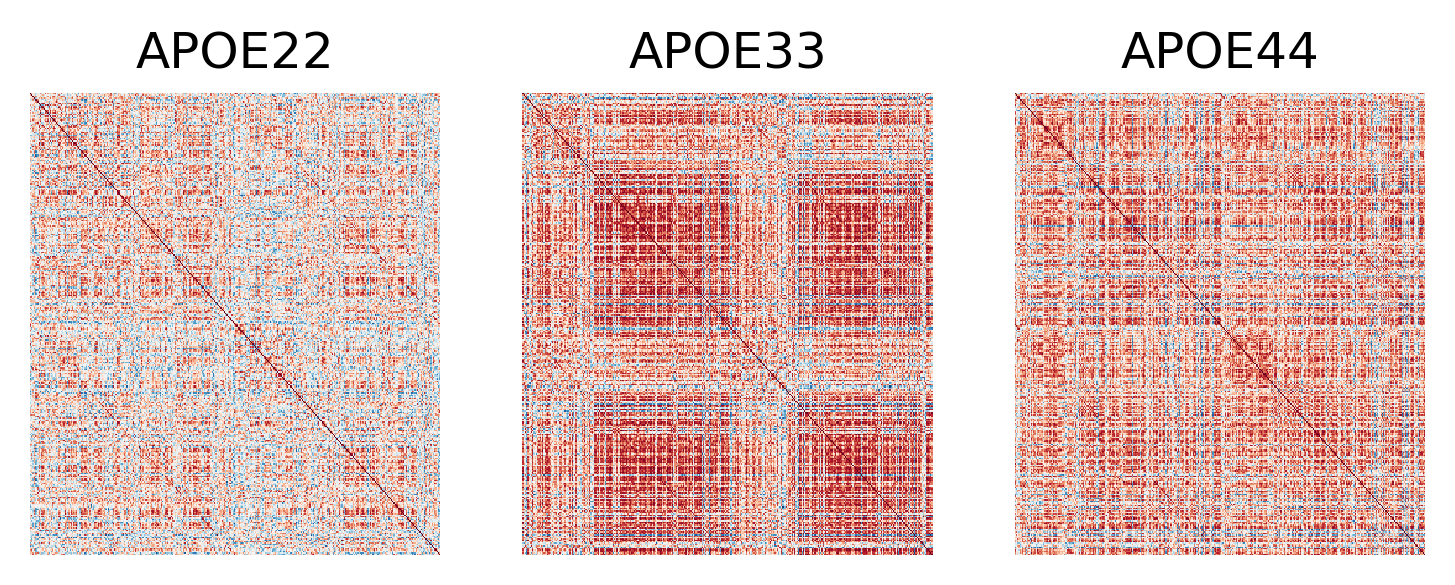

In [6]:
## Plot to make sure nothing is wrong
fig, ax = plt.subplots(1, 3, figsize=(6, 2), dpi=300)

for idx, label in enumerate(labels):
    sns.heatmap(
        correlations[idx],
        ax=ax[idx],
        vmin=-1,
        vmax=1,
        cbar=False,
        cmap="RdBu_r",
        xticklabels=False,
        yticklabels=False,
        center=0,
    )
    ax[idx].set(title=label)

## Vectorize matrix and compute kruskal-wallis

We use KW test for speed since computing large distance distance matrices can be difficult to compute.

In [7]:
# use kruskal-wallis for speed

In [11]:
idx = np.triu_indices_from(correlations[0], k=1)

kruskal(*[c[idx] for c in correlations])

KruskalResult(statistic=9669.864712617768, pvalue=0.0)

## Try apriori community

In [138]:
def group_labels(
    vertex_labels,
):
    out = []

    uniques = np.unique(vertex_labels)

    for pair in combinations_with_replacement(uniques, 2):
        rdx = vertex_labels == pair[0]
        cdx = vertex_labels == pair[1]

        out.append(
            [pair, (rdx, cdx)],
        )

    return out


def run_test(graphs, vertex_labels, test="kruskal"):
    if test == "kruskal":
        tester = kruskal
    elif test.lower() == "dcorr":
        tester = ksample("Dcorr").test

    num_graphs = len(graphs)

    pairs = group_labels(vertex_labels)

    out = []
    for pair, (rdx, cdx) in pairs:
        num_verts = rdx.sum()
        triu_idx = np.triu_indices(num_verts, k=1)

        if not np.all(rdx == cdx):  # deal with off diagonals
            to_test = [g[rdx, :][:, cdx].ravel() for g in graphs]
        else:
            to_test = [g[rdx, :][:, cdx][triu_idx] for g in graphs]

        # res = tester(*to_test)
        res = tester(*[np.abs(i) for i in to_test])
        stat, pval = res[:2]

        to_append = [*pair, stat, pval]
        out.append(to_append)

    columns = ["region1", "region2", "statistic", "pvalue"]
    df = pd.DataFrame(out, columns=columns)

    is_sig, corrected_pvalues, _, _ = multipletests(df["pvalue"], method="holm")
    df["corrected_pvalue"] = corrected_pvalues
    df["significant"] = is_sig

    return df

In [139]:
dfs = [
    run_test(correlations, labels)
    for labels in [
        vertex_hemispheres,
        vertex_structures,
        vertex_hemisphere_structures,
    ]
]

In [141]:
dfs

[  region1 region2    statistic  pvalue  corrected_pvalue  significant
 0       L       L  1781.397984     0.0               0.0         True
 1       L       R  4009.296088     0.0               0.0         True
 2       R       R  2049.432691     0.0               0.0         True,
    region1 region2    statistic         pvalue  corrected_pvalue  significant
 0       FB      FB  1399.243796  1.439032e-304     1.870741e-303         True
 1       FB      HB  1990.354493   0.000000e+00      0.000000e+00         True
 2       FB      MB   637.346526  3.999082e-139     3.999082e-138         True
 3       FB      VS   138.854306   7.049699e-31      4.229819e-30         True
 4       FB      WM  1114.337907  1.058274e-242     1.269928e-241         True
 5       HB      HB   918.642900  3.305436e-200     3.635980e-199         True
 6       HB      MB   575.622276  1.012071e-125     8.096567e-125         True
 7       HB      VS   106.968738   5.916075e-24      2.958038e-23         True
 8  